# KBO Projections Documentation

We had scored the model based on cross-validation up to this point. In this section, I actually check the model against its original function: projecting full season stats (RBI, BA, HRs) for players based on their partial season data (from around the 25-game mark.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv("KBO_Projections_Data_Clean.csv").drop(columns='BA')
proj = pd.read_csv("2020_projections.csv")
new = pd.concat([df[df['Season']==2020],proj],axis=1)
new = new[['Name','Team','PA','RBI_rate','HR_rate','BA']].rename({'PA':'OG_PA','RBI_rate':'proj_RBI_rate','HR_rate':'proj_HR_rate','BA':'proj_BA'},axis=1)

In [3]:
# execute an updated pull for 2020's season stats to compare with our model's projections
team_season_ids = ['55e9e1d3','520fce90','a16474ae','30053a8f','5b7d63c8','48a0549a','dcbb26b6','6fb98b94','e8c5dfdb','d917beac']
raw = pd.DataFrame()
base_url = "https://www.baseball-reference.com/register/team.cgi?id="
with tqdm(total=len(team_season_ids)) as pbar:    
    for id in team_season_ids:
        team_season_url = base_url + id
        html_doc = requests.get(team_season_url).text
        raw_new = pd.DataFrame(pd.read_html(html_doc)[0])
        raw_new['Team'] = str(BeautifulSoup(html_doc).title.string.split()[1]) + " " + str(BeautifulSoup(html_doc).title.string.split()[2])
        raw_new['Season'] = BeautifulSoup(html_doc).title.string.split()[0]
        raw = pd.concat([raw, raw_new], ignore_index=True)
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


In [4]:
# save raw input to csv
raw.to_csv('KBO_2020_Current_Raw_Data.csv')

In [5]:
# perform some data cleaning steps from original
df = pd.read_csv('KBO_2020_Current_Raw_Data.csv')

# delete rows that are team totals and not individual players
df.drop(df.loc[df['Rk'].isna()].index, inplace=True)

# delete cols that aren't substantive
df.drop(columns = ['Rk', 'Notes', 'Unnamed: 0'], inplace=True)

# remove what are now excess characters from name column
df['Name'] = df['Name'].str.replace("*","")
df['Name'] = df['Name'].str.replace("#","")
df['Name'] = df['Name'].str.replace("?","")

In [6]:
# reduce df to relevant columns
df = df[['Name','PA','HR','BA','RBI']]

In [7]:
# convert to rate based on PAs
df['current_HR_rate'] = df.HR / df.PA
df['current_RBI_rate'] = df.RBI / df.PA

In [8]:
compare = new.merge(df,on='Name')

In [9]:
final_analysis = compare[['Name','Team','OG_PA','proj_RBI_rate','proj_HR_rate', 'proj_BA','PA','BA','current_RBI_rate','current_HR_rate']]

In [10]:
final_analysis.to_csv("2020_Season_Analysis.csv")

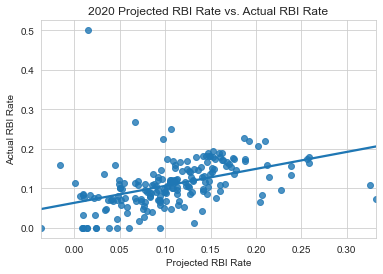

In [11]:
_ = plt.title("2020 Projected RBI Rate vs. Actual RBI Rate")
_ = sns.regplot(data=final_analysis,x='proj_RBI_rate',y='current_RBI_rate',ci=None)
_ = plt.xlabel("Projected RBI Rate")
_ = plt.ylabel("Actual RBI Rate")
plt.savefig("2020_RBI_Residuals.png")

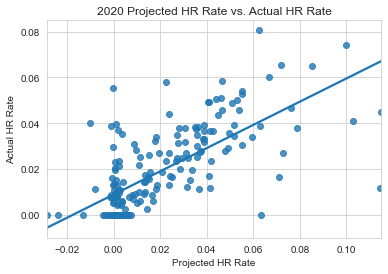

In [12]:
_ = plt.title("2020 Projected HR Rate vs. Actual HR Rate")
_ = sns.regplot(data=final_analysis,x='proj_HR_rate',y='current_HR_rate',ci=None)
_ = plt.xlabel("Projected HR Rate")
_ = plt.ylabel("Actual HR Rate")
plt.savefig("2020_HR_Residuals.png")

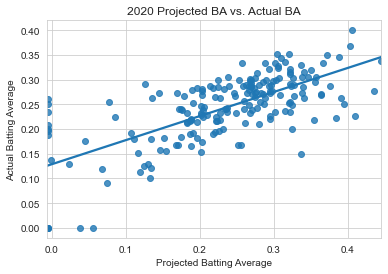

In [13]:
_ = plt.title("2020 Projected BA vs. Actual BA")
_ = sns.regplot(data=final_analysis,x='proj_BA',y='BA',ci=None)
_ = plt.xlabel("Projected Batting Average")
_ = plt.ylabel("Actual Batting Average")
plt.savefig("2020_BA_Residuals.png")

In [14]:
# this splits the 2020 dataframe into players with sufficient sample size to consider for sponsorship
candidates = final_analysis[final_analysis['OG_PA']>100]

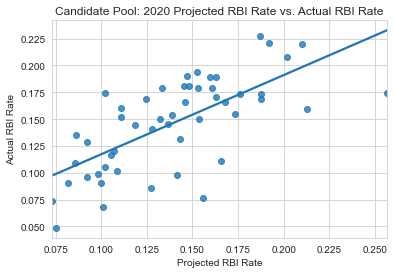

In [15]:
_ = plt.title("Candidate Pool: 2020 Projected RBI Rate vs. Actual RBI Rate")
_ = sns.regplot(data=candidates,x='proj_RBI_rate',y='current_RBI_rate',ci=None)
_ = plt.xlabel("Projected RBI Rate")
_ = plt.ylabel("Actual RBI Rate")
plt.savefig("2020_RBI_Residuals_Candidate_Pool.png")

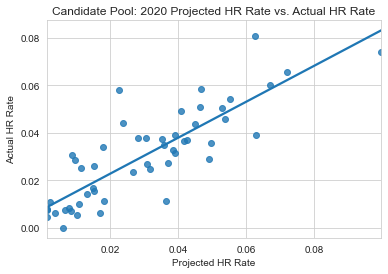

In [16]:
_ = plt.title("Candidate Pool: 2020 Projected HR Rate vs. Actual HR Rate")
_ = sns.regplot(data=candidates,x='proj_HR_rate',y='current_HR_rate',ci=None)
_ = plt.xlabel("Projected HR Rate")
_ = plt.ylabel("Actual HR Rate")
plt.savefig("2020_HR_Residuals_Candidate_Pool.png")

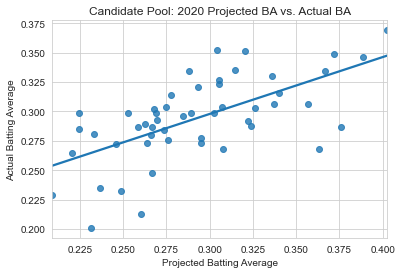

In [17]:
_ = plt.title("Candidate Pool: 2020 Projected BA vs. Actual BA")
_ = sns.regplot(data=candidates,x='proj_BA',y='BA',ci=None)
_ = plt.xlabel("Projected Batting Average")
_ = plt.ylabel("Actual Batting Average")
plt.savefig("2020_BA_Residuals_Candidate_Pool.png")

In [18]:
# this further subsets our candidate pool into what were our ten-most likely candidates based on early season projections
top_ten = candidates[candidates['proj_BA'] > 0.3][candidates['proj_RBI_rate'] > 0.15][candidates['proj_HR_rate'] > 0.03]

C:\Users\abewo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


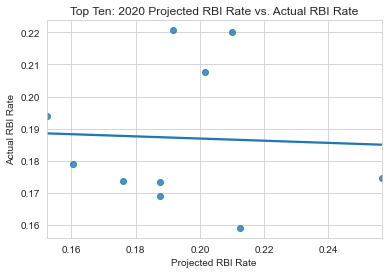

In [19]:
_ = plt.title("Top Ten: 2020 Projected RBI Rate vs. Actual RBI Rate")
_ = sns.regplot(data=top_ten,x='proj_RBI_rate',y='current_RBI_rate',ci=None)
_ = plt.xlabel("Projected RBI Rate")
_ = plt.ylabel("Actual RBI Rate")
plt.savefig("2020_RBI_Residuals_Top_Ten.png")

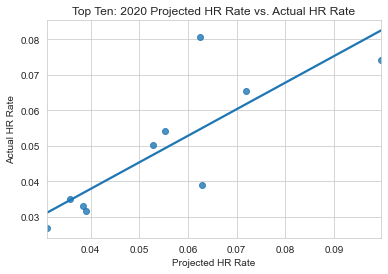

In [20]:
_ = plt.title("Top Ten: 2020 Projected HR Rate vs. Actual HR Rate")
_ = sns.regplot(data=top_ten,x='proj_HR_rate',y='current_HR_rate',ci=None)
_ = plt.xlabel("Projected HR Rate")
_ = plt.ylabel("Actual HR Rate")
plt.savefig("2020_HR_Residuals_Top_Ten.png")

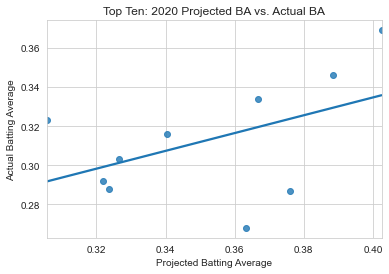

In [21]:
_ = plt.title("Top Ten: 2020 Projected BA vs. Actual BA")
_ = sns.regplot(data=top_ten,x='proj_BA',y='BA',ci=None)
_ = plt.xlabel("Projected Batting Average")
_ = plt.ylabel("Actual Batting Average")
plt.savefig("2020_BA_Residuals_Top_Ten.png")

In [22]:
# who are the current top performers?
final_best = final_analysis[final_analysis['BA'] > 0.25][final_analysis['current_RBI_rate'] > 0.15][final_analysis['current_HR_rate'] > 0.0267]

C:\Users\abewo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


So there were two players (Baek-ho Kang and Jin-Sung Kang) performing at very high levels that we didn't identify, not because the model didn't identify them (it projected them to do very well, in fact), but solely because I made the somewhat arbitrary cutoff at 100 PAs to be included.

Some other top performing players also missed by the projections: Jin-Sung Kang, Hyun Soo Kim, Baek-ho Kang, Ha-Seong Kim, Hyoung-woo Choi, and Jae-il Oh. Again, a lot of the cutoffs I used were arbitrary heuristic decisions by me. But these players all had some sort of major statistical turnaround that the model also didn't predict all that well.

# Of our top ten projected, who would be our top recommendation?
This would have very much been a judgement call, which would have been up to the client. Marketability would likely have been a concern. But if it were solely me picking based on projected statistical performance, I would have picked __Roberto Ramos__, because of his massive projected HR_rate (first out of our top ten) and RBI_rate (also 1st/10). His proj_BA is also the third highest of our top ten.

In [23]:
# we would pick a spokesperson based on these projections
proj_ranks = top_ten.drop(columns=['Team','PA','BA','current_RBI_rate','current_HR_rate'])
proj_ranks['RBI_rank'] = proj_ranks['proj_RBI_rate'].rank(ascending=False)
proj_ranks['HR_rank'] = proj_ranks['proj_HR_rate'].rank(ascending=False)
proj_ranks['BA_rank'] = proj_ranks['proj_BA'].rank(ascending=False)
proj_ranks['Avg_rank'] = proj_ranks[['RBI_rank','HR_rank','BA_rank']].mean(axis=1)
proj_ranks['Overall'] = proj_ranks['Avg_rank'].rank()
proj_ranks

,Name,OG_PA,proj_RBI_rate,proj_HR_rate,proj_BA,RBI_rank,HR_rank,BA_rank,Avg_rank,Overall
4,Jose Miguel Fernandez,139,0.187721,0.038417,0.402489,6.0,8.0,1.0,5.000000,5.0
62,Preston Tucker,134,0.176117,0.055249,0.326477,8.0,5.0,7.0,6.666667,7.0
74,Jung-hoo Lee,139,0.187454,0.039017,0.366699,7.0,7.0,4.0,6.000000,6.0
79,Dong-won Park,109,0.212645,0.062819,0.363377,2.0,3.0,5.0,3.333333,3.0
96,Mel Rojas,131,0.210154,0.062524,0.388348,3.0,4.0,2.0,3.000000,2.0
100,Weun-Sung Chae,121,0.152298,0.030968,0.323775,10.0,10.0,8.0,9.333333,10.0
115,Roberto Ramos,121,0.256604,0.099768,0.376031,1.0,1.0,3.0,1.666667,1.0
128,Dae-ho Lee,127,0.160525,0.035842,0.321912,9.0,9.0,9.0,9.000000,9.0
146,Sung-Bum Na,139,0.201697,0.071879,0.340321,4.0,2.0,6.0,4.000000,4.0
151,Ui-ji Yang,103,0.191785,0.052853,0.305611,5.0,6.0,10.0,7.000000,8.0


# With the hindsight of the 2020 season played so far, who should we have picked?
Statistically speaking, __Mel Rojas__ is probably having the best season so far as a hitter. Roberto Ramos would still have been a fine pick, as he is performing in the top ten overall (tied for eighth).

Mel Rojas _was_ in our recommendation candidates list at the early-season cutoff, as our second-best overall recommendation. But he was admittedly not our top recommendation.

In [24]:
# we should judge based on their season stats to this point
ranks_2020 = final_best.drop(columns=['Team','OG_PA','proj_RBI_rate','proj_HR_rate','proj_BA'])
ranks_2020['RBI_rank'] = ranks_2020['current_RBI_rate'].rank(ascending=False)
ranks_2020['HR_rank'] = ranks_2020['current_HR_rate'].rank(ascending=False)
ranks_2020['BA_rank'] = ranks_2020['BA'].rank(ascending=False)
ranks_2020['Avg_rank'] = ranks_2020[['RBI_rank','HR_rank','BA_rank']].mean(axis=1)
ranks_2020['Overall'] = ranks_2020['Avg_rank'].rank()
ranks_2020

,Name,PA,BA,current_RBI_rate,current_HR_rate,RBI_rank,HR_rank,BA_rank,Avg_rank,Overall
1,Ju-hwan Choi,414,0.299,0.154589,0.028986,29.0,29.0,16.0,24.666667,31.0
4,Jose Miguel Fernandez,485,0.369,0.169072,0.032990,21.0,26.0,1.0,16.000000,13.0
8,Jae-hwan Kim,438,0.273,0.189498,0.045662,7.0,12.0,25.5,14.833333,12.0
11,Jae-il Oh,370,0.330,0.181081,0.037838,9.0,18.0,7.0,11.333333,7.0
44,Hyoung-woo Choi,421,0.334,0.171021,0.035629,20.0,23.0,5.5,16.166667,14.0
58,Ji-wan Na,400,0.299,0.190000,0.037500,6.0,19.0,16.0,13.666667,11.0
62,Preston Tucker,443,0.303,0.173815,0.054176,18.0,6.0,14.0,12.666667,9.0
68,Ha-Seong Kim,486,0.304,0.179012,0.049383,14.0,9.0,12.5,11.833333,8.0
72,Woong-bin Kim,142,0.288,0.161972,0.049296,25.0,10.0,19.5,18.166667,18.5
74,Jung-hoo Lee,473,0.334,0.173362,0.031712,19.0,27.0,5.5,17.166667,16.0
